# Barcode Detection and Scanning

In this session, you are required to implement a basic barcode scanner using image various image processing methods. 

We will be using python's OpenCV library (cv2) for the purpose of preforming image processing tasks.

In [21]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import math
from collections import defaultdict
from matplotlib import pyplot as plt

Please download the image 'input.png' from the given link (https://drive.google.com/file/d/1oQSxTCFiJ2yI7LsmQE3grrYKAdKWPj6Q/view?usp=share_link) and upload it to the current directory of this colab session.

# Barcode Detection

In [2]:
original = cv2.imread('./input.png')
image = original.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

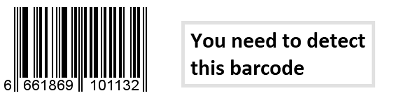

In [48]:
cv2_imshow(image)

Resize the input.png image using cv2.resize() and the show the resized image using cv2_imshow() (which is the colab compatible equivalent for the command cv2.imshow() of OpenCV).

Feel free to look up for the syntaxes on google. :)

In [4]:
resized_image = cv2.resize(image,[150,150]) # Resize the input image

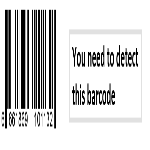

In [5]:
cv2_imshow(resized_image)

In [6]:
image = cv2.resize(image,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC)
original = cv2.resize(original,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC)

Calculate the gradients in x and y directions using cv2.Sobel(). 

Set ksize = -1 to use the **Scharr Operator**.

In [7]:
gradX = cv2.Sobel(image, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(image, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

Show gradX and gradY using cv2_imshow().

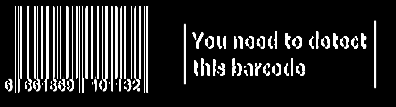

In [8]:
cv2_imshow(gradX)#Display gradX using cv2_imshow()

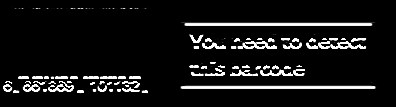

In [9]:
cv2_imshow(gradY)#Display gradY using cv2_imshow()

Calculate the magnitude of gradients as below.

*   $gradient = \sqrt{(gradX)^2 + (gradY)^2}$.

use cv2.sqrt() and cv2.add() for this purpose.

In [16]:
gradient = cv2.sqrt(cv2.add(gradX*gradX,gradY*gradY))

In [17]:
gradient = cv2.convertScaleAbs(gradient) # Converts the output to an 8-bit representation

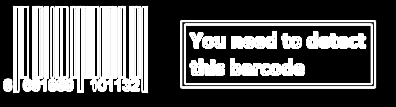

In [18]:
cv2_imshow(gradient)# Display the computed gradient image using cv2_imshow()

Blur the gradient image using cv2.blur(). Use a $3 \times 3$ kernel for the the same.

Further, perform binary thresholding on the blurred image using cv2.threshold(). Use the threshold value of 225, i.e. values below 225 should be mapped to 0, and the values greater than or equal to 225 should be mapped to 255.

In [19]:
blurred = cv2.blur(gradient,(3,3))# Blur the gradient image using cv2.blur() with a 3*3 kernel
(_, thresh) = cv2.threshold(blurred,225,255,cv2.THRESH_BINARY)# Perform binary thresholding on the blurred image with a threshold value of 225

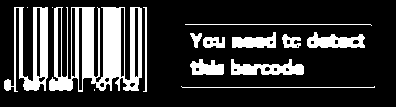

In [20]:
cv2_imshow(thresh)# Display the thresholded image (thresh) of gradients using cv2_imshow()

Create a rectangular kernel of Width = 21 and Height = 7 using cv2.getStructuringElement() along with cv2.MORPH_RECT.

Make sure that the dimensions are written in (Width, Height) format.

Further, using this kernel, perform the morphological closing operation on the image "thresh" using cv2.morphologyEx() along with cv2.MORPH_CLOSE.

In [23]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(21,7))# Define a rectangular kernal with W = 21 and H = 7
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)# Perform the morphological closing operation on "thresh" using the above kernel

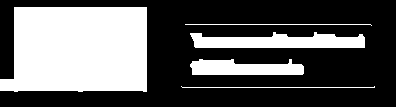

In [25]:
cv2_imshow(closed)# Display the closed image using cv2_imshow()

We further dilate the closed image and find the region with the maximum area.

In [26]:
closed = cv2.dilate(closed, None, iterations = 7) # Performs dilation operation on the closed image
cnts,hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0] # Finds the region with maximum area

We now bound the region of maximum area with a recangular bounding box.

In [27]:
rect = cv2.minAreaRect(c) # Fits a minimum area rectangle over the region with maximum area, hence creating a rectangular bounding box around the barcode
box = np.int0(cv2.boxPoints(rect))

Result of Barcode detection (the red bounding box denotes the output of barcode detection).

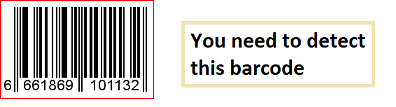

In [28]:
img = original.copy()
cv2.drawContours(img, [box], -1, (0, 0, 255), 1)
cv2_imshow(img)

In [29]:
# This function crops the bounding box
def getSubImage(rect, src):
    center, size, theta = rect 
    size = [size[1],size[0]]
    center, size = tuple(map(int, center)), tuple(map(int, size))
    M = cv2.getRotationMatrix2D( center, theta-90, 1)
    print(src.shape)
    dst = cv2.warpAffine(src, M, [src.shape[1],src.shape[0]])
    out = cv2.getRectSubPix(dst, size, center)
    return out

Result after cropping the bounding box:

(107, 396)


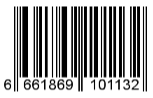

In [30]:
out = getSubImage(rect, image)
cv2_imshow(out)

# Barcode Scanning

In [31]:
out = out.astype('uint8')
out = cv2.cvtColor(out,cv2.COLOR_GRAY2RGB)

In [32]:
encoding_pattern ={
        "111111":0,
        "110100":1,
        "110010":2,
        "110001":3,
        "101100":4,
        "100110":5,
        "100011":6,
        "101010":7,
        "101001":8,
        "100101":9
}
left=[
    {
        "0100111":0,
        "0110011":1,
        "0011011":2,
        "0100001":3,
        "0011101":4,
        "0111001":5,
        "0000101":6,
        "0010001":7,
        "0001001":8,
        "0010111":9   
    },
    {
        "0001101":0,
        "0011001":1,
        "0010011":2,
        "0111101":3,
        "0100011":4,
        "0110001":5,
        "0101111":6,
        "0111011":7,
        "0110111":8,
        "0001011":9   
    }
]
right = {
        "1110010":0,
        "1100110":1,
        "1101100":2,
        "1000010":3,
        "1011100":4,
        "1001110":5,
        "1010000":6,
        "1000100":7,
        "1001000":8,
        "1110100":9 
}

In [43]:
# Write a function that takes in a 3-channel RGB image as input, converts it 
# into a 1-channel grayscale image, and returns the converted grayscale image.
# Note that to convert an RGB image to grayscale, we take the weighted average
# of the RGB components as Gray = 0.2989 * RED + 0.5870 * GREEN + 0.1140 * BLUE
def rgb2gray(rgb):
  # WRITE YOUR CODE HERE
  return cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

# Write a function that takes a 1-channel grayscale image, and the thresholding value 
# as inputs, and performs binary thresholding on the input image with the given threshold.
# i.e. if threshold is thrs, then all pixels with intensity < thrs should become 0, and 
# all pixels with intensity >= thrs should become 255
def thresholding(img, thrs):
  # WRITE YOUR CODE HERE
  return cv2.threshold(img,thrs,255,cv2.THRESH_BINARY)[1]

# This function takes an RGB image as input, converts it into grayscale image, performs 
# binary thresholding on the grayscale image, and then finally returns the image.
def binarise(pic, thrs):
  img = rgb2gray(pic) # Converts the image from RGB to Grayscale
  threshimg = thresholding(img, thrs) # Performs binary thresholding on the input image
  return threshimg

In [34]:
def primitive_crop(row):
    indices = np.where(row == 0)[0]
    if indices.shape[0] == 0:
      return None
    return row[indices[0]:indices[-1]+1]

In [35]:
def convert_binary(bars,nlb):
    binstring = ''
    d = 1
    cnt = 0
    np.append(bars,[-1])
    for i in bars:
      if i == (255 - d*255):
        cnt = cnt + 1
      else:
        if d == 1:
          d = 0
          binstring = binstring + '1'*math.ceil(cnt/nlb)
        else:
          d = 1
          binstring = binstring + '0'*math.floor(cnt/nlb)
        cnt = 1
    return binstring

In [36]:
def find_num_bars(cropped_row):
    num = 0
    for i in cropped_row:
        if i == 255:
            break
        else:
            num += 1
    return num

In [37]:
def find_encoding(bs_list):
    par_str = ""
    for number in range(6):
        parity = 0
        for i in bs_list[number]:
            parity ^= int(i)
        par_str += str(parity)
    return par_str

In [38]:
def get_digits(binary_string,rep_length):
    number_strings = []
    start_pos = 3
    end_pos = len(binary_string) - 3
    i = start_pos
    while(i < end_pos):
        if i == start_pos + rep_length*6:
            i+=5
            continue
        number_strings.append(str(binary_string[i:i+rep_length]))
        i += rep_length
    return number_strings

In [39]:
def decode(encoding_patter_number,bs_list):
    info = ""
    info += str(encoding_pattern[encoding_pattern_number]) + '-'
    for i in range(6):
        # print(info)
        info += str(left[int(encoding_pattern_number[i])][bs_list[i]])
    info += '-'
    for i in range(6,12):
        info += str(right[bs_list[i]])
    return info

Plot the histogram of pixel intensities.

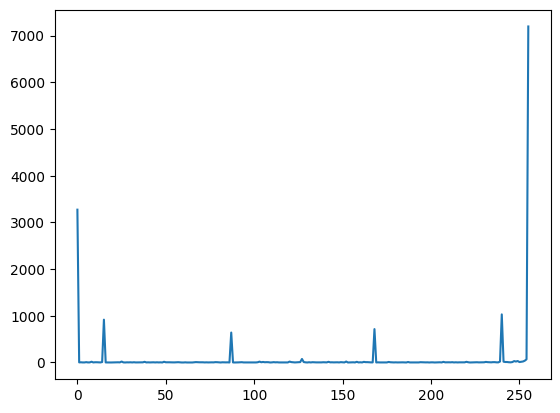

In [40]:
histr = cv2.calcHist([out],[0],None,[256],[0,256])
plt.plot(histr)

In [44]:
image_cropped = out
image_cropped = cv2.resize(image_cropped, (219, 150))

The below cell performs binary thresholding using binarise(inp_img, threshold_value) function. Try out different threshold values and see if the Barcode Detection always works.

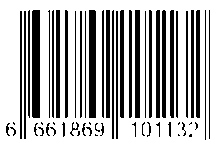

In [45]:
bimg = binarise(image_cropped,100) # Change the thresold parameter and check if the barcode detection works for other values
cv2_imshow(bimg)

**Final Barcode Scanning Algorithm:**

In [46]:
ctr = defaultdict(int)
for row in bimg:
  cropped_row = primitive_crop(row)
  if cropped_row is None:
    continue
  try:
    nlb = find_num_bars(cropped_row)
    binary_string = convert_binary(cropped_row,nlb)
    rep_length = 7
    num_numbers = 13
    bs_list = get_digits(binary_string,rep_length)
    encoding_pattern_number = find_encoding(bs_list)
    information = decode(encoding_pattern_number,bs_list)
    ctr[information] +=1
  except:
    continue

if len(list(ctr.keys())):
  print('Scanned Barcode:',list(ctr.keys())[0])
else:
  print('Barcode Scanning Failed!!!')

Scanned Barcode: 6-661869-101132
